In [218]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.autograd import Variable
from sklearn.metrics import r2_score
from sklearn import preprocessing
#import scipy.io as sio

from models import VAE
from models import DNN
import numpy as np
import pandas as pd
import models

In [219]:
from scipy.stats import pearsonr

# Parameters

In [220]:
# Define parameters
epochs = 500 #200,500,1000  
dim_au_in = 20049
dim_au_out = 512 #8, 16, 32, 64, 128, 256,512
dim_dnn_in = dim_au_out
dim_dnn_out=1
select_drug = 'Cisplatin'

# Import data

In [221]:
data_r=pd.read_csv('data/GDSCexpression.csv',index_col=0)
label_r=pd.read_csv('data/GDSClabel.csv',index_col=0)

In [222]:
label_r=label_r.fillna(1)

In [223]:
label_r.loc[:,:]

,Erlotinib,AICAR,Camptothecin,Vinblastine,Cisplatin,Cytarabine,Docetaxel,Methotrexate,ATRA,Gefitinib,...,CMK,Pyrimethamine,JW-7-52-1,A-443654,GW843682X,MS-275,Parthenolide,MG-132,KIN001-135,TGX221
BxPC-3,1.000000,0.159708,0.188393,0.436127,0.154274,0.113764,0.249987,0.015324,0.015324,0.020293,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
KMOE-2,0.002108,0.339814,0.318206,0.281740,0.063808,0.140681,0.101530,0.191210,0.031229,0.007419,...,0.022662,0.025217,0.270791,0.095608,0.139914,0.171747,0.026670,0.013904,0.002116,0.000956
MFM-223,0.002148,0.334087,0.122671,0.361438,0.051983,0.186659,0.228797,0.003639,0.023043,0.003639,...,0.038997,0.006167,0.002185,0.102592,0.020338,0.010874,0.000970,0.035206,0.007051,0.000323
NUGC-3,1.000000,0.095099,0.416792,0.422631,0.266409,0.237811,0.234952,0.011558,0.028838,0.153002,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
OC-314,1.000000,0.012740,0.479915,0.390145,0.067738,0.125869,0.249668,0.110418,0.002214,0.020309,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KP-N-S19s,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
BC-3,0.003515,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.048227,0.146476,0.400087,0.205247,0.147090,0.298803,0.023796,0.017219,0.002065,0.069181
Panc 08.13,1.000000,0.152818,0.196279,0.180653,0.090963,0.093197,0.097267,0.018269,0.010237,0.009405,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
EKVX,0.177238,0.078395,0.078938,0.072213,0.007225,0.003470,0.129184,0.095642,0.111598,0.126364,...,0.020472,0.044047,0.243635,0.079375,0.019859,0.177759,0.014843,0.114431,0.007216,0.063911


In [224]:
selected_idx = label_r.loc[:,select_drug]!=1

# Your is gene-cell, mine is cell-gene

In [225]:
len(set(data_r.index))

727

In [226]:
data = data_r[selected_idx]
label = label_r.loc[selected_idx,select_drug]
scaler = preprocessing.StandardScaler(with_mean=True, with_std=True)
data = scaler.fit_transform(data)


In [227]:
print(np.std(data))
print(np.mean(data))

1.0
9.829117799766939e-18


In [228]:
data.shape

(675, 11833)

In [229]:
label_r.shape

(789, 139)

# Split test train

In [230]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data, label, test_size=0.2, random_state=42)

In [231]:
print(data.shape)
print(label.shape)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(675, 11833)
(675,)
(540, 11833) (540,)
(135, 11833) (135,)


In [232]:
print(X_train.max())
print(X_train.min())

22.32064566525343
-16.913044973607605


In [233]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)
torch.cuda.set_device(device)

cuda:0


# Add all data to AE

In [234]:
trainData = torch.FloatTensor(X_train).to(device)
testData = torch.FloatTensor(X_test).to(device)
y = torch.FloatTensor(Y_train.values).to(device)
allData = torch.FloatTensor(data).to(device)

# construct TensorDataset
train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
all_dataset = TensorDataset(allData, allData)

trainDataLoader1 = DataLoader(dataset=train_dataset, batch_size=200, shuffle=False)
trainDataLoaderall = DataLoader(dataset=all_dataset, batch_size=200, shuffle=False)

In [235]:
dataloader = trainDataLoaderall

# The model

In [236]:
model = VAE(dim_au_in=data_r.shape[1],dim_au_out=128)
if torch.cuda.is_available():
    model.cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
reconstruction_function = nn.SmoothL1Loss()

In [237]:
loss_train = np.zeros((epochs, 1))

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(dataloader):
        img, _ = data
        img = img.view(img.size(0), -1)
        img = Variable(img)
        if torch.cuda.is_available():
            img = img.cuda()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(img)
        loss = models.vae_loss(recon_batch, img, mu, logvar,reconstruction_function)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
             
    loss_train[epoch,0] = loss.item()  
    print('Epoch: %04d, Training loss=%.8f' %
          (epoch+1, loss.item()))

torch.save(model.state_dict(), 'saved/models/vae.pth')

D:\anaconda3\lib\site-packages\torch\nn\functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 0001, Training loss=435.66418457
Epoch: 0002, Training loss=227.34948730
Epoch: 0003, Training loss=146.82661438
Epoch: 0004, Training loss=103.66944885
Epoch: 0005, Training loss=76.37157440
Epoch: 0006, Training loss=58.99320984
Epoch: 0007, Training loss=46.76211929
Epoch: 0008, Training loss=37.52946472
Epoch: 0009, Training loss=30.51655579
Epoch: 0010, Training loss=25.01723671
Epoch: 0011, Training loss=21.04143524
Epoch: 0012, Training loss=18.05273056
Epoch: 0013, Training loss=15.68579006
Epoch: 0014, Training loss=13.81253529
Epoch: 0015, Training loss=12.39556694
Epoch: 0016, Training loss=11.31699657
Epoch: 0017, Training loss=10.56795406
Epoch: 0018, Training loss=10.18374920
Epoch: 0019, Training loss=9.90042686
Epoch: 0020, Training loss=9.66532135
Epoch: 0021, Training loss=9.46712494
Epoch: 0022, Training loss=9.02877998
Epoch: 0023, Training loss=8.32121658
Epoch: 0024, Training loss=8.07711124
Epoch: 0025, Training loss=11.30444431
Epoch: 0026, Training loss=

Epoch: 0218, Training loss=2.49807048
Epoch: 0219, Training loss=2.53607154
Epoch: 0220, Training loss=2.68219447
Epoch: 0221, Training loss=2.86499834
Epoch: 0222, Training loss=3.03231812
Epoch: 0223, Training loss=3.16516972
Epoch: 0224, Training loss=3.21358418
Epoch: 0225, Training loss=3.21840143
Epoch: 0226, Training loss=3.16964674
Epoch: 0227, Training loss=3.03279710
Epoch: 0228, Training loss=2.88505983
Epoch: 0229, Training loss=2.73652530
Epoch: 0230, Training loss=2.58875680
Epoch: 0231, Training loss=2.49734855
Epoch: 0232, Training loss=2.45696783
Epoch: 0233, Training loss=2.50522828
Epoch: 0234, Training loss=2.65311718
Epoch: 0235, Training loss=2.90040326
Epoch: 0236, Training loss=3.22361565
Epoch: 0237, Training loss=3.67387938
Epoch: 0238, Training loss=4.31257153
Epoch: 0239, Training loss=5.11966133
Epoch: 0240, Training loss=6.00149584
Epoch: 0241, Training loss=6.77064228
Epoch: 0242, Training loss=7.15197420
Epoch: 0243, Training loss=7.16431236
Epoch: 0244,

Epoch: 0435, Training loss=5.15181065
Epoch: 0436, Training loss=5.20808458
Epoch: 0437, Training loss=5.23259497
Epoch: 0438, Training loss=4.95903206
Epoch: 0439, Training loss=4.64467049
Epoch: 0440, Training loss=4.23183107
Epoch: 0441, Training loss=3.86394739
Epoch: 0442, Training loss=3.56759667
Epoch: 0443, Training loss=3.30458188
Epoch: 0444, Training loss=3.11683440
Epoch: 0445, Training loss=2.97384596
Epoch: 0446, Training loss=2.86533976
Epoch: 0447, Training loss=2.79909921
Epoch: 0448, Training loss=2.80125904
Epoch: 0449, Training loss=2.86781669
Epoch: 0450, Training loss=2.99241614
Epoch: 0451, Training loss=3.14240313
Epoch: 0452, Training loss=3.26413107
Epoch: 0453, Training loss=3.35593677
Epoch: 0454, Training loss=3.44287872
Epoch: 0455, Training loss=3.52168751
Epoch: 0456, Training loss=3.61771393
Epoch: 0457, Training loss=3.69581389
Epoch: 0458, Training loss=3.76191902
Epoch: 0459, Training loss=3.67772770
Epoch: 0460, Training loss=3.63089371
Epoch: 0461,

In [238]:
recon_batch, mu, logvar = model(trainData)

In [239]:
feature = mu.cpu().detach().numpy()

In [260]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.001)
clf.fit(feature, Y_train.values)

Lasso(alpha=0.001)

In [265]:
from sklearn.ensemble import AdaBoostRegressor
regr = AdaBoostRegressor(random_state=0, n_estimators=100)
regr.fit(feature, Y_train.values)

AdaBoostRegressor(n_estimators=100, random_state=0)

In [243]:
_recon_batch, testFeature, _logvar = model(testData)
lasso = clf.predict(testFeature.detach().cpu().numpy())

D:\anaconda3\lib\site-packages\torch\nn\functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [266]:
adaboost = clf.predict(testFeature.detach().cpu().numpy())

In [244]:
r2_score(lasso,Y_test)

-95279325571572.25

In [267]:
r2_score(adaboost,Y_test)

-95279325571572.25

In [245]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(feature)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 540 samples in 0.007s...
[t-SNE] Computed neighbors for 540 samples in 0.060s...
[t-SNE] Computed conditional probabilities for sample 540 / 540
[t-SNE] Mean sigma: 0.035334
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.411369
[t-SNE] KL divergence after 300 iterations: 0.842990


In [246]:
tsne_results

array([[-0.44635877, -9.594072  ],
       [-1.3699114 , -5.1074886 ],
       [10.973329  , -0.38312718],
       ...,
       [ 0.9975797 , -9.836095  ],
       [-9.14996   , -0.3812821 ],
       [ 8.176882  , -8.188568  ]], dtype=float32)

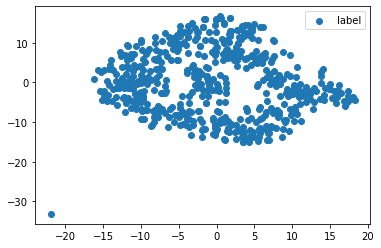

In [247]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], label="label")
plt.legend()
plt.savefig("saved/figures/tsne_vae_gdsc.png")

In [248]:
EPOCH = 500

In [249]:
# Load data
# data type conversion
B_feature = torch.FloatTensor(feature).to(device)
y = torch.FloatTensor(Y_train.values).to(device)
# construct TensorDataset
b_data = TensorDataset(B_feature, y)
trainDataLoader2 = DataLoader(dataset=b_data, batch_size=200, shuffle=False)

In [250]:
# Initialization DNN model

predictor = DNN(128, dim_dnn_out).to(device)
optimizer = optim.Adam(predictor.parameters(), lr=1e-3,betas=(0.9,0.99))
#loss1-softmax
loss_func = nn.MSELoss().to(device)
#loss2-sigmoid
#loss_func = nn.BCELoss()
#loss3-sigmoid
#loss_func = nn.CrossEntropyLoss()

#criterion = torch.nn.MSELoss(size_average=True)
#criterion = torch.nn.BCELoss(size_average=True) # Defined loss function
#optimizer = optim.Adm(model.parameters(), lr=0.01) # Defined optimizer
loss_train = np.zeros((epochs, 1))

In [251]:
# train model
for epoch in range(EPOCH):
    print('Epoch: ',epoch)
    for step,(batch_x,batch_y) in enumerate(trainDataLoader2):
        b_x = Variable(batch_x)
        b_y = Variable(batch_y)
        # predict label
        output = predictor(b_x)
        # b_y=F.sigmoid(b_y) 
        
        #print
        #print(output)
        #print(b_y)
        # compute loss
        loss = loss_func(output,b_y)
        #loss = criterion(output, b_y)
        
        # update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train[epoch,0] = loss.item()  
    print('Epoch: %04d, Training loss=%.8f' %
          (epoch+1, loss.item())) 

# Save model
torch.save(predictor.state_dict(), 'saved/models/DNN_GDSC.pkl')

Epoch:  0
Epoch: 0001, Training loss=0.15940861
Epoch:  1
Epoch: 0002, Training loss=0.15287048
Epoch:  2
Epoch: 0003, Training loss=0.14638048
Epoch:  3
Epoch: 0004, Training loss=0.13940901
Epoch:  4
Epoch: 0005, Training loss=0.13189700
Epoch:  5
Epoch: 0006, Training loss=0.12362639
Epoch:  6
Epoch: 0007, Training loss=0.11453197
Epoch:  7
Epoch: 0008, Training loss=0.10461202
Epoch:  8
Epoch: 0009, Training loss=0.09392172
Epoch:  9
Epoch: 0010, Training loss=0.08262192
Epoch:  10
Epoch: 0011, Training loss=0.07096790
Epoch:  11
Epoch: 0012, Training loss=0.05934255
Epoch:  12
Epoch: 0013, Training loss=0.04821935
Epoch:  13
Epoch: 0014, Training loss=0.03807456
Epoch:  14
Epoch: 0015, Training loss=0.02927183
Epoch:  15
Epoch: 0016, Training loss=0.02205614
Epoch:  16
Epoch: 0017, Training loss=0.01654110
Epoch:  17
Epoch: 0018, Training loss=0.01263995
Epoch:  18
Epoch: 0019, Training loss=0.01008122
Epoch:  19
Epoch: 0020, Training loss=0.00853498
Epoch:  20
Epoch: 0021, Traini

D:\anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([140])) that is different to the input size (torch.Size([140, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0022, Training loss=0.00727784
Epoch:  22
Epoch: 0023, Training loss=0.00712578
Epoch:  23
Epoch: 0024, Training loss=0.00710556
Epoch:  24
Epoch: 0025, Training loss=0.00714042
Epoch:  25
Epoch: 0026, Training loss=0.00718620
Epoch:  26
Epoch: 0027, Training loss=0.00722012
Epoch:  27
Epoch: 0028, Training loss=0.00723318
Epoch:  28
Epoch: 0029, Training loss=0.00722439
Epoch:  29
Epoch: 0030, Training loss=0.00719671
Epoch:  30
Epoch: 0031, Training loss=0.00715492
Epoch:  31
Epoch: 0032, Training loss=0.00710415
Epoch:  32
Epoch: 0033, Training loss=0.00704914
Epoch:  33
Epoch: 0034, Training loss=0.00699378
Epoch:  34
Epoch: 0035, Training loss=0.00694103
Epoch:  35
Epoch: 0036, Training loss=0.00689294
Epoch:  36
Epoch: 0037, Training loss=0.00685051
Epoch:  37
Epoch: 0038, Training loss=0.00681426
Epoch:  38
Epoch: 0039, Training loss=0.00678415
Epoch:  39
Epoch: 0040, Training loss=0.00675960
Epoch:  40
Epoch: 0041, Training loss=0.00674013
Epoch:  41
Epoch: 0042, Trainin

Epoch: 0191, Training loss=0.00662639
Epoch:  191
Epoch: 0192, Training loss=0.00662631
Epoch:  192
Epoch: 0193, Training loss=0.00662623
Epoch:  193
Epoch: 0194, Training loss=0.00662615
Epoch:  194
Epoch: 0195, Training loss=0.00662607
Epoch:  195
Epoch: 0196, Training loss=0.00662600
Epoch:  196
Epoch: 0197, Training loss=0.00662592
Epoch:  197
Epoch: 0198, Training loss=0.00662585
Epoch:  198
Epoch: 0199, Training loss=0.00662578
Epoch:  199
Epoch: 0200, Training loss=0.00662570
Epoch:  200
Epoch: 0201, Training loss=0.00662563
Epoch:  201
Epoch: 0202, Training loss=0.00662557
Epoch:  202
Epoch: 0203, Training loss=0.00662550
Epoch:  203
Epoch: 0204, Training loss=0.00662543
Epoch:  204
Epoch: 0205, Training loss=0.00662537
Epoch:  205
Epoch: 0206, Training loss=0.00662530
Epoch:  206
Epoch: 0207, Training loss=0.00662523
Epoch:  207
Epoch: 0208, Training loss=0.00662517
Epoch:  208
Epoch: 0209, Training loss=0.00662511
Epoch:  209
Epoch: 0210, Training loss=0.00662505
Epoch:  210


Epoch: 0366, Training loss=0.00662101
Epoch:  366
Epoch: 0367, Training loss=0.00662100
Epoch:  367
Epoch: 0368, Training loss=0.00662099
Epoch:  368
Epoch: 0369, Training loss=0.00662098
Epoch:  369
Epoch: 0370, Training loss=0.00662097
Epoch:  370
Epoch: 0371, Training loss=0.00662096
Epoch:  371
Epoch: 0372, Training loss=0.00662094
Epoch:  372
Epoch: 0373, Training loss=0.00662093
Epoch:  373
Epoch: 0374, Training loss=0.00662093
Epoch:  374
Epoch: 0375, Training loss=0.00662091
Epoch:  375
Epoch: 0376, Training loss=0.00662089
Epoch:  376
Epoch: 0377, Training loss=0.00662088
Epoch:  377
Epoch: 0378, Training loss=0.00662088
Epoch:  378
Epoch: 0379, Training loss=0.00662088
Epoch:  379
Epoch: 0380, Training loss=0.00662085
Epoch:  380
Epoch: 0381, Training loss=0.00662083
Epoch:  381
Epoch: 0382, Training loss=0.00662083
Epoch:  382
Epoch: 0383, Training loss=0.00662083
Epoch:  383
Epoch: 0384, Training loss=0.00662081
Epoch:  384
Epoch: 0385, Training loss=0.00662080
Epoch:  385


In [252]:
testpredict = predictor(testFeature)

In [253]:
testpredict

tensor([[0.0947],
        [0.0909],
        [0.0905],
        [0.0882],
        [0.0971],
        [0.0968],
        [0.0915],
        [0.0890],
        [0.0951],
        [0.0935],
        [0.0942],
        [0.0956],
        [0.0957],
        [0.0958],
        [0.0922],
        [0.0895],
        [0.0947],
        [0.0932],
        [0.0993],
        [0.0928],
        [0.0904],
        [0.0953],
        [0.0948],
        [0.0888],
        [0.0931],
        [0.0930],
        [0.0930],
        [0.0954],
        [0.0939],
        [0.0903],
        [0.0904],
        [0.0931],
        [0.0941],
        [0.0932],
        [0.0948],
        [0.0952],
        [0.0941],
        [0.0974],
        [0.0950],
        [0.0953],
        [0.0947],
        [0.0918],
        [0.0938],
        [0.0913],
        [0.0951],
        [0.0963],
        [0.0942],
        [0.0930],
        [0.0973],
        [0.0970],
        [0.0981],
        [0.0978],
        [0.0933],
        [0.0882],
        [0.0923],
        [0

In [254]:
from sklearn.metrics import mean_squared_error

In [255]:
r2_score(testpredict.detach().cpu().numpy(),Y_test)

-720.0183535148651

In [256]:
mean_squared_error(testpredict.detach().cpu().numpy(),Y_test)

0.005350307933550169